In [303]:
import numpy as np
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep


$\text {Diagonal} \rightarrow 1 \\$ 
$\text {Not Diagonal} \rightarrow 0$ 

In [304]:
# Data Generation
images,labels=generate_dataset(img_size=5,
                              n_images=300,
                              binary=True,
                              seed=13)


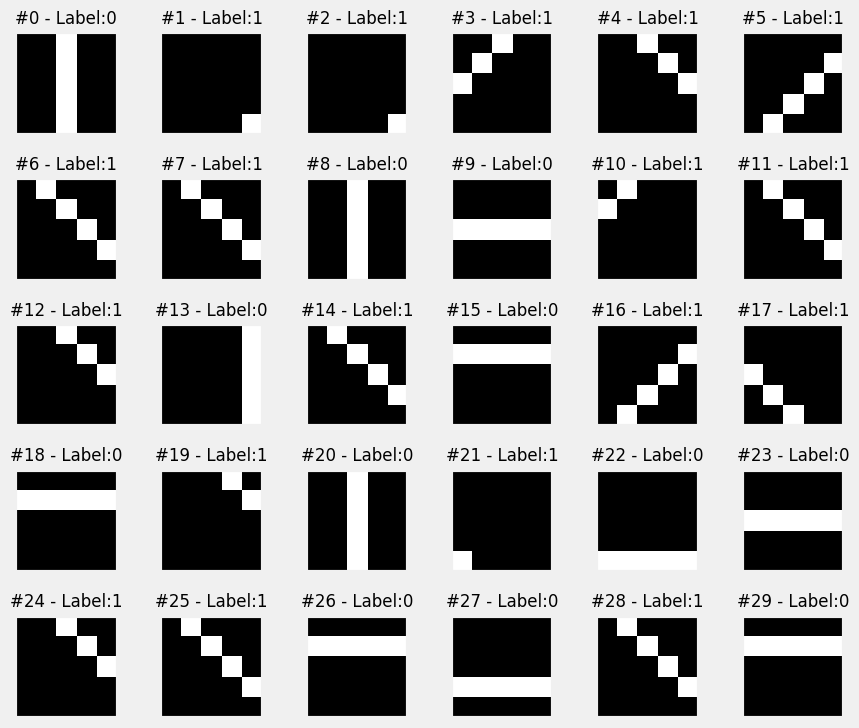

In [305]:
from plots.chapter4 import plot_images

fig=plot_images(images,labels,n_plot=30)

In [306]:
# images and channels
image_r=np.zeros((5,5),dtype=np.uint8)
image_r[:,0]=255
image_r[:,1]=128

image_g=np.zeros((5,5),dtype=np.uint8)
image_g[:,1]=128
image_g[:,2]=255
image_g[:,3]=128

image_b=np.zeros((5,5),dtype=np.uint8)
image_b[:,3]=128
image_b[:,4]=255

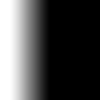

In [307]:
Image.fromarray(image_r).resize((100,100))

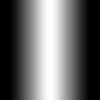

In [308]:
Image.fromarray(image_g).resize((100,100))

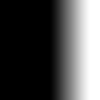

In [309]:
Image.fromarray(image_b).resize((100,100))

In [310]:
image_gray=0.2126*image_r+0.7152*image_g+0.722*image_b
image_gray=image_gray.astype(np.int16)
image_gray

array([[ 54, 118, 182, 183, 184],
       [ 54, 118, 182, 183, 184],
       [ 54, 118, 182, 183, 184],
       [ 54, 118, 182, 183, 184],
       [ 54, 118, 182, 183, 184]], dtype=int16)

In [311]:
image_rgb=np.stack([image_r,image_b,image_b])


$\text {NCHW vs NHWC: Expected shape of Mini batch}$  
* PyTorch: NCHW
* TF: NHWC
* PIL: HWC

In [312]:
images.shape

(300, 1, 5, 5)

In [313]:
example=images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [314]:
example.shape

(1, 5, 5)

In [315]:
# image in HWC
exampl_hwc=np.transpose(example,(1,2,0))
exampl_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

In [316]:
exampl_hwc.shape

(5, 5, 1)

## Transformations  
1. Transformation based on images
2. Transformation based on tensors

**Conversion transoforms**  
* ToPILImage()  
* ToTensor()

In [317]:
exampl_hwc.dtype

dtype('uint8')

In [318]:
tensorizer=ToTensor() # scale values from [0,255] to [0,1] if dtype==unit8
example_tensor=tensorizer(exampl_hwc)
example_tensor


tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [319]:
example_img=ToPILImage()(example_tensor) # tensor in CHW (pytorch) or numpy array in HWC
print(type(example_img))

<class 'PIL.Image.Image'>


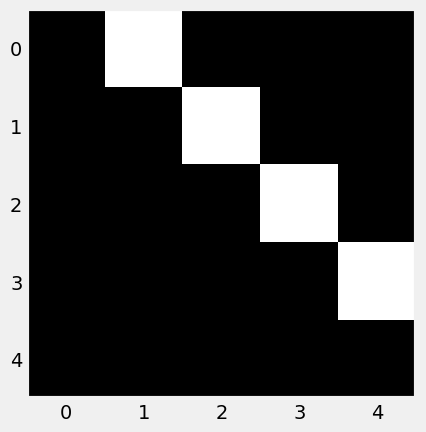

In [320]:
plt.imshow(example_img,cmap='gray')
plt.grid(False)

## Transforms on Images  
1. Resize()  
2. CenterCrop()
3. GrayScale()
4. RandomHorizontalFlip()
5. RandomRotation()

## Transforms on tensor  
There are 4 transforms that take non image tensors as inputs. 
1. LinearTransformation()
2. Normalize()
3. RandomErasing()
4. ConvertImageDtype()

In [321]:
flipper=RandomHorizontalFlip(p=1.0)
flipped_img=flipper(example_img)
flipped_img

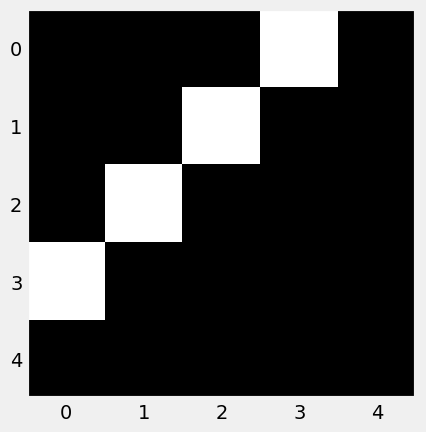

In [322]:
plt.imshow(flipped_img,cmap='gray')
plt.grid(False)

In [323]:
img_tensor=tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

## Normalize Transform  
This function applies to channels

In [324]:
normalizer=Normalize(mean=(0.5),std=(0.5)) # each channel have seperate means and std
normalized_tensor=normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

## Composed Transforms

In [325]:
composer=Compose([RandomHorizontalFlip(p=1.0),
                  Normalize(mean=(0.5),std=(0.5))])
composer

Compose(
    RandomHorizontalFlip(p=1.0)
    Normalize(mean=0.5, std=0.5)
)

In [326]:
composed_tensor=composer(example_tensor)
composed_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

In [327]:
(composed_tensor==normalized_tensor).all()

tensor(True)

In [328]:
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [329]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [330]:
example_tensor=torch.as_tensor(example/255,dtype=torch.float32)
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

## Data Preparation

In [331]:
# Build tensors from numpy arrays
X_tensor=torch.as_tensor(images/255,dtype=torch.float32)
y_tensor=torch.as_tensor(labels.reshape(-1,1),dtype=torch.float32)

## Dataset Transforms

In [332]:
# We build a custom dataset that is capable of handling transformations
class TransformedTensorDataset(Dataset):
    def __init__(self,X,y,transform=None): # if traformation is None, it behaves similar to TensorDataset
        self.X=X
        self.y=y
        self.transform=transform

    def __getitem__(self,index):
        X=self.X[index]

        if self.transform:
            X=self.transform(X)

        return X, self.y[index]
    
    def __len__(self):
        return len(self.X)

In [333]:
composer=Compose([RandomHorizontalFlip(p=0.5),
                  Normalize(mean=(0.5),std=(0.5))])
dataset=TransformedTensorDataset(X_tensor,y_tensor,transform=composer)

In [334]:
dataset

## SubsetRandomSampler  
Lets create 2 shuffled list of indices for training and validation dataset

In [335]:
def index_splitter(n,splits,seed=13): # n: number of data points, splits: relative weights of split sizes
    idx=torch.arange(n)
    # Make the split argument tensor
    split_tensor=torch.as_tensor(splits)
    # finds the correct multiplier
    multiplier=n/split_tensor.sum()
    split_tensor=(multiplier*split_tensor).long()
    # If there is a difference, throws at the first split
    diff=n-split_tensor.sum()
    split_tensor[0]+=diff
    # Uses pytorch random split to split the indices
    torch.manual_seed(seed)
    return random_split(idx,split_tensor) # random_split needs exact number of data points

In [336]:
train_idx,val_idx=index_splitter(len(X_tensor),[80,20])
train_idx

In [337]:
np.transpose(train_idx.indices)

array([118, 170, 148, 239, 226, 146, 168, 195,   6, 180, 157,   2, 160,
        66,  46, 276, 126, 212, 119,  77,  53, 237, 252, 202, 200, 289,
       135, 186, 231, 211,  35, 293, 229, 265, 256, 134, 191, 214,   8,
        83, 150, 190, 208, 209, 275,  60, 295, 142, 251, 176, 260,   3,
        31,   0, 137,  20,  81, 287, 181, 129, 166,  97, 110, 206, 267,
       241, 109, 177,  27,  52,  43, 245, 247, 141,  68, 131, 217,  78,
       185,  49,  96,  14, 111, 234, 284, 263, 269, 101,  32, 285,  79,
       297,  94,  85,  11,   5,  80, 165, 183,   4,  33, 100,  73, 235,
       277,  16, 144, 132, 167, 130,  45,  48, 201,  99,  34, 138, 178,
       244, 225, 173,  95,  22, 197, 174,  90, 223, 274,  92, 279,  19,
        74,  28, 162, 133, 151,  37, 299,  18, 203,  13, 156, 268, 259,
       116,  70,  71, 230, 108, 238,  47, 163,  30, 188,  64, 216, 121,
       187,  72, 221, 258,  44, 179, 272, 159, 253, 280, 140, 120,  62,
       271,  57,   1, 149,   9,  29, 194, 158, 115, 198, 294,  1

In [338]:
# each subset object is used as an argument to the corresponding sampler
# sampler is used to draw random indices from given list
train_sampler=SubsetRandomSampler(train_idx) 
val_sampler=SubsetRandomSampler(val_idx)


In [339]:
# split is controlled by samplers
# Since you are using a sampler, you cannot use shuffle=True
train_loader=DataLoader(dataset=dataset,
                        sampler=train_sampler,
                        batch_size=16)

val_loader=DataLoader(dataset=dataset,
                      sampler=val_sampler,
                      batch_size=16)


In [340]:
len(iter(train_loader)),len(iter(val_loader))

(15, 4)

## Data Augmentation Transforms

In [341]:
# Use indices to perform split
X_train_tensor=X_tensor[train_idx]
y_train_tensor=y_tensor[train_idx]
X_val_tensor=X_tensor[val_idx]
y_val_tensor=y_tensor[val_idx]

Train composer: augment and scales data  
Val composer: scales data

In [342]:
train_composer=Compose([RandomHorizontalFlip(p=0.5),Normalize(mean=0.5,std=0.5)])
val_composer=Compose([Normalize(mean=0.5,std=0.5)])

In [343]:
# Create Datasets
train_dataset=TransformedTensorDataset(X_train_tensor,y_train_tensor,transform=train_composer)
val_dataset=TransformedTensorDataset(X_val_tensor,y_val_tensor,transform=val_composer)

# Create dataloaders
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16)

If you do not perform Data augmentation, use a singale dataset with samplers.

## Weighted Random Sampler

Instead of weights for  loss, we use weights for sampling

In [344]:
classes,counts=y_train_tensor.unique(return_counts=True)
print(classes,counts)

tensor([0., 1.]) tensor([ 80, 160])


In [345]:
weights=1.0/counts.float()
weights

tensor([0.0125, 0.0063])

In [346]:
sample_weights=weights[y_train_tensor.squeeze().long()]  # labels used as indices

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10])

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [347]:
len(sample_weights)

240

In [348]:
generator=torch.Generator()

sampler=WeightedRandomSampler(weights=sample_weights,
                              num_samples=len(sample_weights),
                              replacement=True,
                              generator=generator)

In [349]:
sampler

In [350]:
train_loader=DataLoader(train_dataset,batch_size=16,sampler=sampler)
val_loader=DataLoader(val_dataset,batch_size=16)

In [351]:
# Helper function 5
def make_balanced_sampler(y):
    # compute weights for compensating imbalance classes
    classes,counts=y.unique(return_counts=True)
    weights=1.0/counts.float()
    sample_weights=weights[y.squeeze().long()]
    # Build a sampler with computed weights
    generator=torch.Generator()
    sampler=WeightedRandomSampler(weights=sample_weights,
                                  num_samples=len(sample_weights),
                                  replacement=True,
                                  generator=generator)
    return sampler



In [352]:
sampler=make_balanced_sampler(y_train_tensor)

In [353]:
train_loader.sampler.generator.manual_seed(42) # seed for generator
random.seed(42) # seed for pythons random module

We have 160 exampels in positive class. we are sampling 123 out of them. We are oversampling the negative class which had 80 to 117. Our dataset is balanced now

In [354]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

In [355]:
def set_seed(self,seed=42):
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

setattr(StepByStep,'set_seed',set_seed)

## Data Preparation (put it all together)

In [356]:
# Build tensors from numpy arrays
X_tensor=torch.as_tensor((images/255),dtype=torch.float32)
y_tensor=torch.as_tensor(labels.reshape(-1,1),dtype=torch.float32)

# Use index splitter to generate indices
train_idx,val_idx=index_splitter(len(y_tensor),splits=[80,20])

# Uses indices to perform split
X_train_tensor=X_tensor[train_idx]
y_train_tensor=y_tensor[train_idx]
X_val_tensor=X_tensor[val_idx]
y_val_tensor=y_tensor[val_idx]

# Build composers
train_composer=Compose([RandomHorizontalFlip(p=0.5),
                        Normalize(mean=0.5,std=0.5)])
val_composer=Compose([Normalize(mean=0.5,std=0.5)])

# Uses custom dataset to apply composed transforms
train_dataset=TransformedTensorDataset(X_train_tensor,
                                       y_train_tensor,
                                       transform=train_composer)
val_dataset=TransformedTensorDataset(X_val_tensor,
                                     y_val_tensor,
                                     transform=val_composer)

# Build weighted random sampler
sampler=make_balanced_sampler(y_train_tensor)

# Uses sampler in training data to ge a balanced DataLoader
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=16,
                        sampler=sampler)
val_loader=DataLoader(dataset=val_loader,
                      batch_size=16)


## Pixels as features  


In [357]:
dummy_xs,dummy_ys=next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [358]:
flattener=nn.Flatten() # preserves 1st dimention
dummy_xs_flat=flattener(dummy_xs)

print(f"dummy_xs_flat shape: {dummy_xs_flat.shape}\n\n{dummy_xs_flat[0]}")

dummy_xs_flat shape: torch.Size([16, 25])

tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


## Shallow Model

$$
P(y = 1 | \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x}) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x})}}

$$

# Model configuration

In [359]:
# set learning rate
lr=0.1

torch.manual_seed(17)
# create a model
model_logistic=nn.Sequential()
model_logistic.add_module('flatten',nn.Flatten())
model_logistic.add_module('linear',nn.Linear(25,1,bias=False))
model_logistic.add_module('sigmoid',nn.Sigmoid())

# Define SGD optimizer
optimizer_logistic=optim.SGD(model_logistic.parameters(),
                             lr=lr)

# define Binary cross entropy loss function
binary_loss_fn=nn.BCELoss()

## Model Training

In [361]:
# n_epochs=100

# sbs_logistic=StepByStep(model=model_logistic,
#                         loss_fn=binary_loss_fn,
#                         optimizer=optimizer_logistic)

# sbs_logistic.set_loaders(train_loader,val_loader)
# sbs_logistic.train(n_epochs)

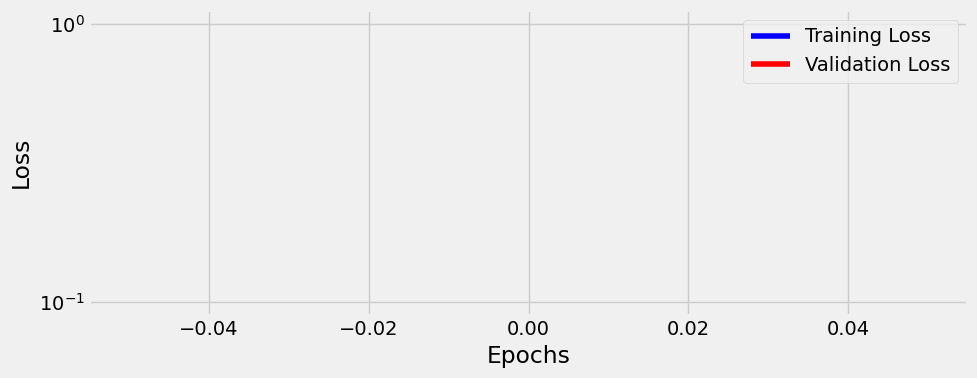

In [ ]:
fig=sbs_logistic.plot_losses()